In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.datasets import make_blobs
from skactiveml.pool import UncertaintySampling
from skactiveml.utils import unlabeled_indices, MISSING_LABEL
from skactiveml.classifier import SklearnClassifier
from skactiveml.visualization import plot_decision_boundary, plot_utilities

In [2]:
# Generate data set.
dataset = pd.read_csv('dataset-tortuga.csv')
dataset = dataset.drop('NAME', axis=1).dropna(axis=0)

profile_options = np.unique(dataset['PROFILE'])
for index, profile in enumerate(profile_options):
    dataset.loc[dataset['PROFILE'] == profile,'PROFILE'] = index

target = 'PROFILE'
X = np.array(dataset.drop(target, axis=1).values.tolist())[:, 6:8] # keep explanatory variables in X
y_true = np.array(dataset[target]).astype('int') # keep the response variable in y

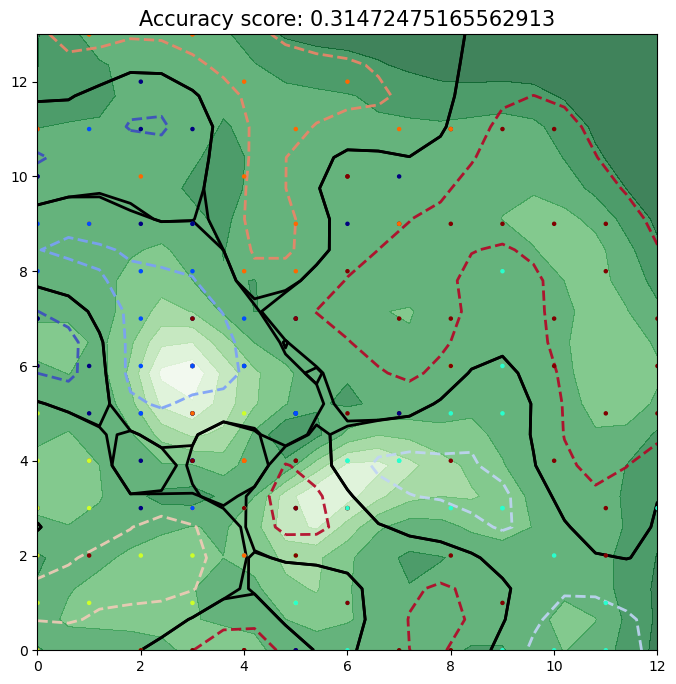

In [6]:
# GaussianProcessClassifier needs initial training data otherwise a warning will
# be raised by SklearnClassifier. Therefore, the first 10 instances are used as
# training data.
y = np.full(shape=y_true.shape, fill_value=MISSING_LABEL)

# GaussianProcessClassifier needs initial training data otherwise a warning will
# be raised by SklearnClassifier. Therefore, the first 100 instances are used as
# training data.
y[:100] = y_true[:100]

# Create classifier and query strategy.
clf = SklearnClassifier(GaussianProcessClassifier(random_state=0),classes=np.unique(y_true), random_state=0)
qs = UncertaintySampling(method='entropy')

# Execute active learning cycle.
n_cycles = 100
for c in range(n_cycles):
    query_idx = qs.query(X=X, y=y, clf=clf)
    y[query_idx] = y_true[query_idx]

# Fit final classifier.
clf.fit(X, y)

# Visualize resulting classifier and current utilities.
bound = [[min(X[:, 0]), min(X[:, 1])], [max(X[:, 0]), max(X[:, 1])]]
unlbld_idx = unlabeled_indices(y)
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
ax.set_title(f'Accuracy score: {clf.score(X,y_true)}', fontsize=15)
plot_utilities(qs, X=X, y=y, clf=clf, feature_bound=bound, ax=ax)
plot_decision_boundary(clf, feature_bound=bound, confidence=0.6)
#plt.scatter(X[unlbld_idx,0], X[unlbld_idx,1], c='gray', s=5)
plt.scatter(X[:,0], X[:,1], c=y, cmap='jet', s=5)
plt.show()